In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be used

In [25]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be usedimport tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import pandas as pd
import math
import tensorflow as tf
import random

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
MAX_HEIGHT = 1072
MAX_WIDTH = 1912
shrink = 8
HEIGHT = MAX_HEIGHT // shrink
WIDTH = MAX_WIDTH // shrink
batch_size = 64
print(HEIGHT, WIDTH)

134 239


In [6]:
tensor = tf.convert_to_tensor([1, 2, 3, 4], dtype=tf.float32)
tensor / 5

<tf.Tensor: id=2, shape=(4,), dtype=float32, numpy=array([0.2, 0.4, 0.6, 0.8], dtype=float32)>

In [7]:
def get_classes_info(root_dir: str, height, width):
    labels = set()
    counter = 0
    classes_num = {}
    with open(os.path.join(root_dir, 'localization.txt'), 'r') as file:
        for line in file:
            line = line.strip()
            character = line.split(',')[-1]
            if character not in labels:
                labels.add(character)
                classes_num[character] = 0
            classes_num[character] += 1
            counter += 1
    labels = sorted(list(labels))
    return labels, classes_num, counter

def convertion(labels: list):
    convert_to_categorical = {character: ind for ind, character in enumerate(labels)}
    return convert_to_categorical

def preprocess_image(image, coords):
    image = tf.image.decode_jpeg(image, channels=3)
    height, width, channels = image.shape
    # print(image.shape)
    x_1, y_1, x_2, y_2 = coords
    x_1, x_2 = x_1 * WIDTH / width, x_2 * WIDTH / width
    y_1, y_2 = y_1 * HEIGHT / height, y_2 * HEIGHT / height
    coords = tf.convert_to_tensor([x_1, y_1, x_2, y_2])
    # print(coords)
    coords = tf.math.round(coords)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image /= 255.0
    return image, coords


def load_and_preprocess(image_path, coords):
    image = tf.io.read_file(image_path)
    return preprocess_image(image, coords)

def parse_input(root_dir: str, height, width):
    images = []
    answers_coord = []
    answers_class = []
    file_path = os.path.join(root_dir, 'localization.txt')
    # print(file_path)
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip().split(',')
            x_1, y_1, x_2, y_2 = map(int, line[1:5])
            x_1, x_2 = min(x_1, x_2), max(x_1, x_2)
            y_1, y_2 = min(y_1, y_2), max(y_1, y_2)
            image_path = os.path.join(root_dir, line[0])
            coords = (x_1, y_1, x_2, y_2)
            # print(coords)
            image, coords = load_and_preprocess(image_path, coords)
            # print(coords)
            images.append(image)
            answers_coord.append(coords)
            answers_class.append(tf.keras.utils.to_categorical(convert_to_categorical[line[5]], len(labels)))
    return images, answers_coord, answers_class

In [8]:
labels, classes_num, total = get_classes_info('the-simpsons-characters-dataset', 0, 0)
# print(labels)
for character, cnt in sorted(classes_num.items(), key=lambda x: -x[1]):
    print(character, ':', cnt)
print('\n', total)
print(len(labels))
convert_to_categorical = convertion(labels)
images, answers_coord, answers_class = parse_input('the-simpsons-characters-dataset', 0, 0)
print(images)

charles_montgomery_burns : 650
homer_simpson : 612
abraham_grampa_simpson : 595
ned_flanders : 595
lisa_simpson : 562
marge_simpson : 557
bart_simpson : 554
principal_skinner : 506
krusty_the_clown : 226
nelson_muntz : 219
moe_szyslak : 215
kent_brockman : 213
edna_krabappel : 212
milhouse_van_houten : 210
chief_wiggum : 209
comic_book_guy : 208
apu_nahasapeemapetilon : 206
sideshow_bob : 171

 6720
18


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
len(images), len(answers_coord), len(answers_class)

(6720, 6720, 6720)

In [50]:
def show_image_with_box(image, coord, character):
    coord = coord.numpy()
    plt.imshow(image)
    plt.axvline(x=coord[0],color='red')
    plt.axvline(x=coord[2],color='red')
    plt.axhline(y=coord[1],color='red')
    plt.axhline(y=coord[3],color='red')
    plt.xlabel(labels[character.argmax()])
    # plt.show()

In [51]:
x1, y1, x2, y2 = answers_coord[5000].numpy()
x1, y1, x2, y2

(1.0, 50.0, 95.0, 107.0)

In [52]:
character = answers_class[5000].argmax()
labels[character]

'nelson_muntz'

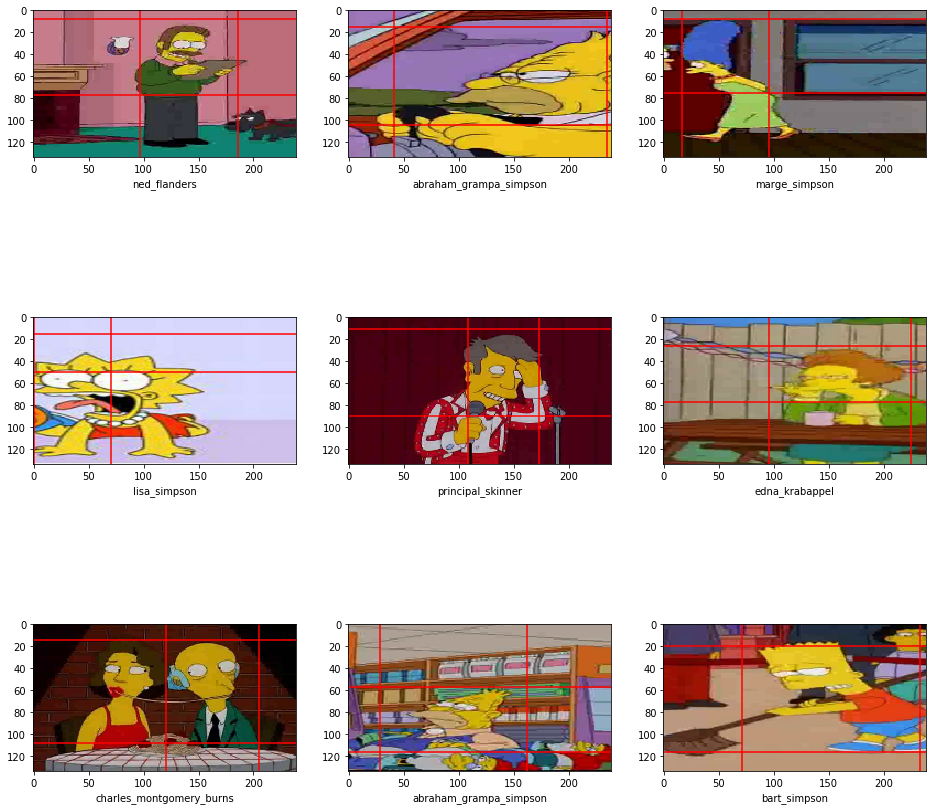

In [68]:
sizes = len(answers_coord)
plt.figure(figsize=(16, 16))
i = 0
for ind in [random.randint(0, sizes - 1) for x in range(9)]:
    plt.subplot(3, 3,i+1)
    show_image_with_box(images[ind], answers_coord[ind], answers_class[ind])
    i += 1
plt.show()

483

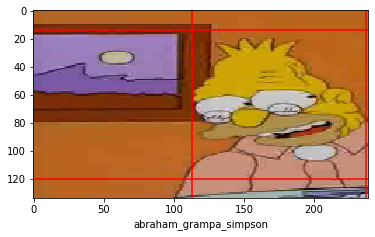

In [56]:
ind = random.randint(0, sizes - 1)
show_image_with_box(images[ind], answers_coord[ind], answers_class[ind])
ind